# Next steps:

- ~~add the .rw.dat parsing to `DatFile` (with `raw` options in higher level classes where appropriate)~~
  - https://www.qdusa.com/siteDocs/appNotes/1500-022.pdf
- ~~add raw options to `MvsH`, `ZFCFC`, and `Dataset`~~
- come up with an `Analysis` prototype/ABC
- implement `SimpleMvsHAnalysis` (getting things like `M_s`, `H_c`, `H_r`, etc. with appropriate scaling factors)
- implement basic serialization (i.e., `as_dict()` on all classes)
- create documentation and GitHub page
- add some basic plotting functionality

In [1]:
from __future__ import annotations
import json
from dataclasses import dataclass, InitVar
import re
from collections import OrderedDict
import csv
from datetime import datetime
import numpy as np
import pandas as pd
from pathlib import Path
import magnetopy as mp
from magnetopy import DatFile, GenericFile
from magnetopy.data_files import filename_label, DcMeasurement, ScanHeader, RawScan, ProcessedScan
from magnetopy.parsing_utils import label_clusters, unique_values, find_outlier_indices, find_temp_turnaround_point, find_sequence_starts
from magnetopy import MvsH, ZFCFC, ZFC, FC, SampleInfo, Dataset
from magnetopy.experiments import _num_digits_after_decimal, _scale_dc_data, _add_uncorrected_moment_columns

import matplotlib.pyplot as plt

from pydantic import BaseModel

In [2]:
DATA_PATH = Path("data")

mvsh1_dat = DatFile(DATA_PATH / "mvsh1.dat")
mvsh2_dat = DatFile(DATA_PATH / "mvsh2.dat")
mvsh2a_dat = DatFile(DATA_PATH / "mvsh2a.dat")
mvsh2b_dat = DatFile(DATA_PATH / "mvsh2b.dat")
mvsh2c_dat = DatFile(DATA_PATH / "mvsh2c.dat")
mvsh3_dat = DatFile(DATA_PATH / "mvsh3.dat")
mvsh4_dat = DatFile(DATA_PATH / "mvsh4.dat")
mvsh5_dat = DatFile(DATA_PATH / "mvsh5.dat")
mvsh5rw_dat = DatFile(DATA_PATH / "mvsh5.rw.dat")
mvsh6_dat = DatFile(DATA_PATH / "mvsh6.dat")
mvsh7_dat = DatFile(DATA_PATH / "mvsh7.dat")
mvsh8_dat = DatFile(DATA_PATH / "mvsh8.dat")
mvsh9_dat = DatFile(DATA_PATH / "mvsh9.dat")
mvsh10_dat = DatFile(DATA_PATH / "mvsh10.dat")
mvsh11_dat = DatFile(DATA_PATH / "mvsh11.dat")
zfcfc1_dat = DatFile(DATA_PATH / "zfcfc1.dat")
zfcfc2_dat = DatFile(DATA_PATH / "zfcfc2.dat")
zfcfc3_dat = DatFile(DATA_PATH / "zfcfc3.dat")
zfcfc4_dat = DatFile(DATA_PATH / "zfcfc4.dat")
fc4a_dat = DatFile(DATA_PATH / "fc4a.dat")
fc4b_dat = DatFile(DATA_PATH / "fc4b.dat")
zfc4a_dat = DatFile(DATA_PATH / "zfc4a.dat")
zfc4b_dat = DatFile(DATA_PATH / "zfc4b.dat")
fc5_dat = DatFile(DATA_PATH / "fc5.dat")
fc5rw_dat = DatFile(DATA_PATH / "fc5.rw.dat")
zfc5_dat = DatFile(DATA_PATH / "zfc5.dat")
zfc5rw_dat = DatFile(DATA_PATH / "zfc5.rw.dat")
dataset4_dat = DatFile(DATA_PATH / "dataset4.dat")
pd_std1_dat = DatFile(DATA_PATH / "Pd_std1.dat")


In [3]:
commented_mvsh_dat = [mvsh4_dat, mvsh5_dat]
commented_mvsh_dat_w_dset = [mvsh4_dat, mvsh5_dat, dataset4_dat]
uncommented_mvsh_dat = [mvsh1_dat, mvsh2_dat, mvsh2a_dat, mvsh2b_dat, mvsh3_dat, mvsh6_dat, mvsh7_dat, mvsh8_dat, mvsh9_dat, mvsh10_dat, mvsh11_dat, pd_std1_dat]

In [4]:
mvsh1_2 = MvsH(mvsh1_dat, 2)
mvsh1_4 = MvsH(mvsh1_dat, 4)
mvsh1_6 = MvsH(mvsh1_dat, 6)
mvsh1_8 = MvsH(mvsh1_dat, 8)
mvsh1_10 = MvsH(mvsh1_dat, 10)
mvsh1_12 = MvsH(mvsh1_dat, 12)
mvsh1_300 = MvsH(mvsh1_dat, 300)

mvsh2_5 = MvsH(mvsh2_dat, 5)
mvsh2_300 = MvsH(mvsh2_dat, 300)
mvsh2a_5 = MvsH(mvsh2a_dat, 5)
mvsh2b_300 = MvsH(mvsh2b_dat, 300)
mvsh2c_5 = MvsH(mvsh2c_dat, 5)
mvsh2c_300 = MvsH(mvsh2c_dat, 300)

mvsh3_5 = MvsH(mvsh3_dat, 5)

mvsh4_293 = MvsH(mvsh4_dat, 293)

mvsh4ds_293 = MvsH(dataset4_dat, 293)

mvsh5_293 = MvsH(mvsh5_dat, 293)

mvsh6_300 = MvsH(mvsh6_dat, 300)

mvsh7_300 = MvsH(mvsh7_dat, 300)

mvsh8_2 = MvsH(mvsh8_dat, 2)

mvsh9_2 = MvsH(mvsh9_dat, 2)

mvsh10_5 = MvsH(mvsh10_dat, 5)

mvsh11_5 = MvsH(mvsh11_dat, 5)

pd_std1_300 = MvsH(pd_std1_dat, 300)

mvsh1 = [mvsh1_2, mvsh1_4, mvsh1_6, mvsh1_8, mvsh1_10, mvsh1_12, mvsh1_300]
mvsh2 = [mvsh2_5, mvsh2_300, mvsh2a_5, mvsh2b_300]
mvsh_commented = [mvsh4_293, mvsh4ds_293, mvsh5_293]
mvsh_rest = [mvsh3_5, mvsh6_300, mvsh7_300, mvsh8_2, mvsh9_2, pd_std1_300]

mvsh_uncommented = mvsh1 + mvsh2 + mvsh_rest

mvsh_all = mvsh1 + mvsh2 + mvsh_commented + mvsh_rest

In [5]:
uncommented_zfcfc_dat = [zfcfc1_dat, zfcfc2_dat, zfcfc3_dat]
uncommented_zfc_dat = [zfc5_dat]
uncommented_fc_dat = [fc5_dat]
commented_zfcfc_dat = [zfcfc4_dat]
commented_zfc_dat = [zfc4a_dat, zfc4b_dat]
commented_fc_dat = [fc4a_dat, fc4b_dat]


In [6]:
name = "zfc5"
file = DATA_PATH / f"{name}.dat"
file_raw = DATA_PATH / f"{name}.rw.dat"
zfc = ZFC(file, parse_raw=True)

In [7]:
dset = Dataset(DATA_PATH / "dataset1")

In [8]:
dset.sample_info.mass, dset.sample_info.molecular_weight, dset.sample_info.eicosane_mass

(19.8, 1566.22, 32.4)

In [9]:
dset.mvsh

[MvsH at 2 K,
 MvsH at 4 K,
 MvsH at 6 K,
 MvsH at 8 K,
 MvsH at 10 K,
 MvsH at 12 K,
 MvsH at 300 K]

In [10]:
mvsh = dset.get_mvsh(2)

In [11]:
mvsh.scaling

['molar', 'eicosane']

In [12]:
forward = mvsh.simplified_data("forward")
reverse = mvsh.simplified_data("reverse")

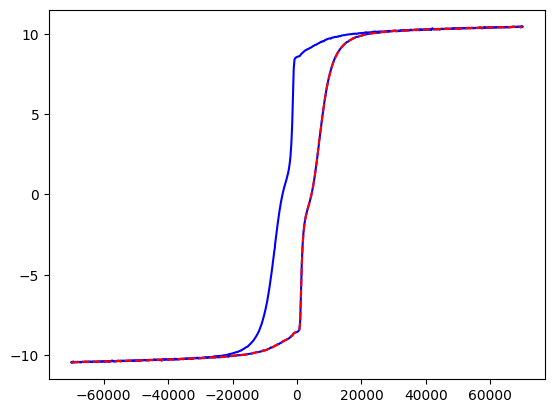

In [13]:
fig, ax = plt.subplots()
ax.plot(reverse['field'], reverse['moment'], c='b')
ax.plot(-reverse['field'], -reverse['moment'], c='b')
ax.plot(forward['field'], forward['moment'], c='r', ls='--')

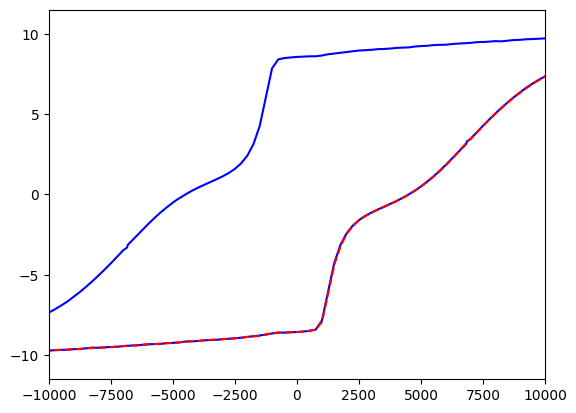

In [14]:
ax.set_xlim(-10000, 10000)
fig

In [15]:
m_r = forward['moment'].iloc[forward['field'].abs().idxmin()]
m_r

-8.573830159070367

In [16]:
h_c = reverse['field'].iloc[reverse['moment'].abs().idxmin()]
h_c

-4501.643555

In [17]:
m_s = (forward['moment'].max() + abs(forward['moment'].min())) / 2
m_s

10.466703114161271

In [18]:
analysis = mp.SimpleMvsHAnalysis(
    dset,
    mp.SimpleMvsHAnalysisParsingArgs(
        temperature=2
    ),
)
print(analysis.results)

SimpleMvsHAnalysisResults(m_s=10.467101768993821, h_c=4501.3806155, m_r=8.573807168964388, moment_units='bohr magnetons/mol', field_units='Oe', segments=['forward', 'reverse'])


In [19]:
analysis.mvsh.origin_file

'mvsh1.dat'

In [20]:
dset.add_analysis(analysis)

In [21]:
serialized = json.dumps(dset, default=lambda x: x.as_dict(), indent=4)
print(serialized)

{
    "sample_id": "dataset1",
    "sample_info": {
        "material": "[Er(TiPS2COT)I(THF)]2",
        "comment": "salmon powder in eicosane",
        "mass": 19.8,
        "volume": null,
        "molecular_weight": 1566.22,
        "size": null,
        "shape": null,
        "holder": "Straw",
        "holder_detail": "Standard",
        "offset": 66.27,
        "eicosane_mass": 32.4,
        "diamagnetic_correction": 0.0
    },
    "mvsh": [
        {
            "origin_file": "mvsh1.dat",
            "temperature": 2,
            "field_range": [
                -70000.35156,
                70000.375
            ],
            "field_correction_file": "",
            "scaling": [
                "molar",
                "eicosane"
            ]
        },
        {
            "origin_file": "mvsh1.dat",
            "temperature": 4,
            "field_range": [
                -70000.28125,
                70000.28906
            ],
            "field_correction_file": "",
  

In [22]:
print(dset.as_json(4))

{
    "sample_id": "dataset1",
    "sample_info": {
        "material": "[Er(TiPS2COT)I(THF)]2",
        "comment": "salmon powder in eicosane",
        "mass": 19.8,
        "volume": null,
        "molecular_weight": 1566.22,
        "size": null,
        "shape": null,
        "holder": "Straw",
        "holder_detail": "Standard",
        "offset": 66.27,
        "eicosane_mass": 32.4,
        "diamagnetic_correction": 0.0
    },
    "mvsh": [
        {
            "origin_file": "mvsh1.dat",
            "temperature": 2,
            "field_range": [
                -70000.35156,
                70000.375
            ],
            "field_correction_file": "",
            "scaling": [
                "molar",
                "eicosane"
            ]
        },
        {
            "origin_file": "mvsh1.dat",
            "temperature": 4,
            "field_range": [
                -70000.28125,
                70000.28906
            ],
            "field_correction_file": "",
  

In [23]:
dset.create_report()

Report written to data/dataset1/dataset1.json
